In [63]:
 import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../")

In [183]:
import torch
import numpy as np
import slayerSNN as snn
from pathlib import Path
import logging
from snn_models.baseline_snn import SlayerMLP
from torch.utils.data import DataLoader
from dataset import ViTacDataset

np.random.seed(0)

In [207]:
class FLAGS():
    def __init__(self):
        self.batch_size = 64
        self.tsample = 325
        self.theta = 10
        self.output_size = 20
        self.tauRho = 1
        self.sc_true = 150
        self.sc_false = 2
        self.hidden_size = 32#128
        self.sample_file = 1#4
        self.tsr_stop = 325
        self.lr = 0.001
        self.data_dir = '../../data_VT_SNN_2/'
args = FLAGS()

In [208]:
for i in range(1,10,1):
    samples = np.loadtxt(args.data_dir + 'test_80_20_'+str(i)+'.txt').astype("int")
    _, bb = np.unique( samples[:,1], return_counts=True )
    print('Test', bb)
    samples = np.loadtxt(args.data_dir + 'train_80_20_'+str(i)+'.txt').astype("int")
    _, bb = np.unique( samples[:,1], return_counts=True )
    print('Train', bb)

Test [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Train [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
Test [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Train [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
Test [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Train [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
Test [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Train [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
Test [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Train [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
Test [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Train [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]
Test [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Train [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]
Test [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Train [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]
Test [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Train [16 16 16 16 16 16 16 16 16

In [209]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": args.theta, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": args.tauRho, # 1
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": args.tsample, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": args.tsr_stop,
            },
            "tgtSpikeCount": {True: args.sc_true, False: args.sc_false},
        }
    },
}

input_size = 156  # Tact
output_size = args.output_size # 20

device = torch.device("cuda:2")
net = SlayerMLP(params, input_size, args.hidden_size, output_size).to(device)

error = snn.loss(params).to(device)

In [210]:
model_dir = '../../../tas_python_env/.guild/runs/1859c0a3249e40ad808cf9d18a3d5dcc/'

In [211]:
os.listdir(model_dir)

['weights-500-179.546.pt',
 'weights-100-261.462.pt',
 'weights-400-198.211.pt',
 'weights-200-227.597.pt',
 'weights-300-198.586.pt',
 'events.out.tfevents.1586708464.beast-CLeAR.3549.0',
 '.guild']

In [212]:
net.load_state_dict(torch.load(model_dir + 'weights-500-179.546.pt'))
net.eval()

SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(156, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(32, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [213]:
train_dataset = ViTacDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4
)
test_dataset = ViTacDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [214]:
correct = 0

with torch.no_grad():
    for i, (tact, _, target, label) in enumerate(test_loader):
        tact = tact.to(device)
        target = target.to(device)
        output = net.forward(tact)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()

        spike_loss = error.numSpikes(output, target)
    test_acc = correct/ len(test_loader.dataset)

In [215]:
correct = 0

with torch.no_grad():
    for i, (tact, _, target, label) in enumerate(train_loader):
        tact = tact.to(device)
        target = target.to(device)
        output = net.forward(tact)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()

        spike_loss = error.numSpikes(output, target)
    train_acc = correct/ len(train_loader.dataset)

In [216]:
train_acc, test_acc

(0.9703125, 0.375)

In [218]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn


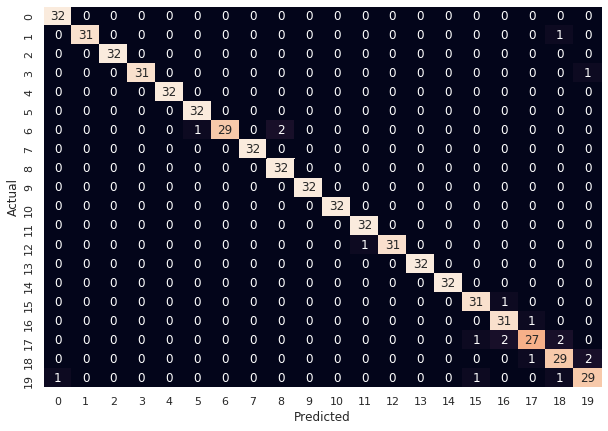

In [219]:
count = 0
total_testing_true=None
testing_true = torch.zeros([len(train_dataset),2])
ll = []
for i, (tact, _, target, label) in enumerate(train_loader, 0):
    testing_true[count:count+label.shape[0],0] = label
    with torch.no_grad():
        # Forward pass of the network.
        tact = tact.to(device)
        out_tact = net.forward(tact)
        predicted_label = snn.predict.getClass(out_tact)
        testing_true[count:count+label.shape[0],1] = predicted_label
    count += label.shape[0]
    ll.append(label)
if total_testing_true is None:
    total_testing_true = testing_true
else:
    total_testing_true = torch.cat([total_testing_true, testing_true])
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy())   
plt.figure(figsize = (10,7))
plt.tight_layout(True)
sn.heatmap(cm, annot=True, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(f"{save_dir}/{run.id}_test.png")
plt.show()

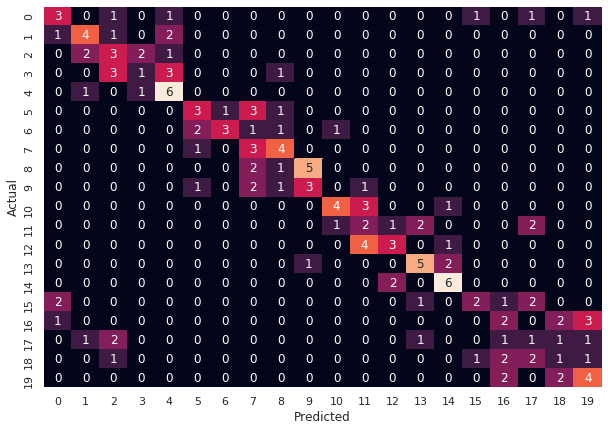

In [220]:
count = 0
total_testing_true=None
testing_true = torch.zeros([len(test_dataset),2])
ll = []
for i, (tact, _, target, label) in enumerate(test_loader, 0):
    testing_true[count:count+label.shape[0],0] = label
    with torch.no_grad():
        # Forward pass of the network.
        tact = tact.to(device)
        out_tact = net.forward(tact)
        predicted_label = snn.predict.getClass(out_tact)
        testing_true[count:count+label.shape[0],1] = predicted_label
    count += label.shape[0]
    ll.append(label)
if total_testing_true is None:
    total_testing_true = testing_true
else:
    total_testing_true = torch.cat([total_testing_true, testing_true])
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy())   
plt.figure(figsize = (10,7))
plt.tight_layout(True)
sn.heatmap(cm, annot=True, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(f"{save_dir}/{run.id}_test.png")
plt.show()

In [221]:
ss = torch.cat(ll)

In [222]:
ss

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
        15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19])

In [223]:
x_unique = ss.unique(sorted=True)
x_unique_count = torch.stack([(ss==x_u).sum() for x_u in x_unique])

In [224]:
x_unique_count

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [225]:
sn.set(style="white", palette="muted", color_codes=True)

In [228]:
# batch2
list_of_objects2 = [
    "Pepsi 0",
    "Pepsi 25",
    "Pepsi 50",
    "Pepsi 75",
    "Pepsi 100",
    "Tuna 0",
    "Tuna 25",
    "Tuna 50",
    "Tuna 75",
    "Tuna 100",
    "Soy 0",
    "Soy 25",
    "Soy 50",
    "Soy 75",
    "Soy 100",
    "Coffee 0",
    "Coffee 25",
    "Coffee 50",
    "Coffee 75",
    "Coffee 100",
]


In [233]:
cm = cm.T

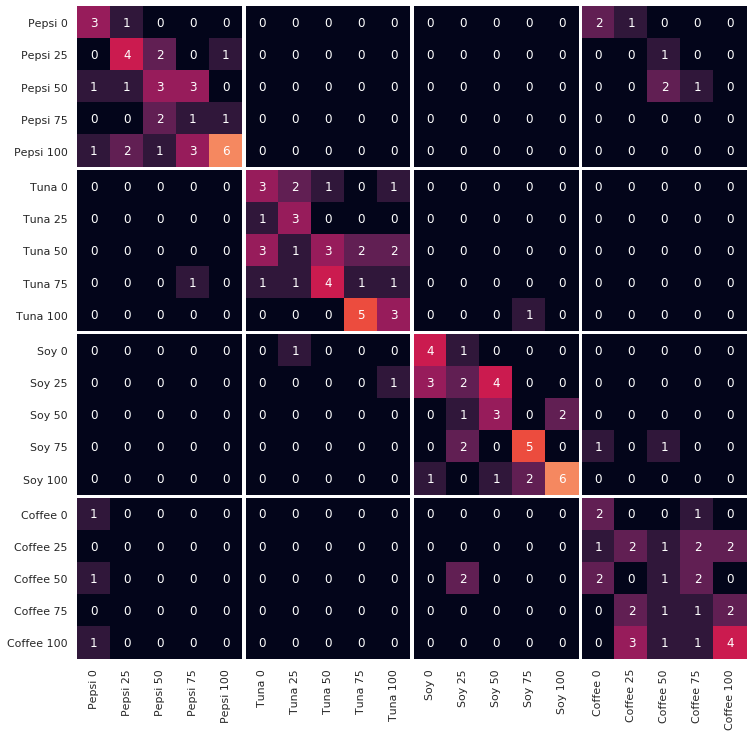

In [234]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(12,12))

for i in range(0,20,5):
    for j in range(0,20,5):
        if i == 15:
            xticklabels = list_of_objects2[j:j+5]
        else:
            xticklabels = False
        if j == 0:
            yticklabels = list_of_objects2[i:i+5]
        else:
            yticklabels = False
            
        sn.heatmap(cm[i:i+5,j:j+5], annot=True, cbar=False,
                   ax=ax[int(i/5)][int(j/5)], vmin=0, vmax=8,
                  xticklabels=xticklabels, yticklabels=yticklabels)
plt.subplots_adjust(hspace=0.02, wspace=0.02)
plt.show()